# Convolutional Neural Networks with PyTorch and FashionMNIST

In this notebook, we'll explore Convolutional Neural Networks (CNNs) using PyTorch and the FashionMNIST dataset. We'll cover both theoretical concepts and practical implementation, building a TinyVGG model from scratch.

Before starting with the code, please watch this excellent video by MIT on CNNs so you have a solid understanding: [MIT 6.S191: Convolutional Neural Networks](https://youtu.be/oGpzWAlP5p0?si=xjY-L0CcOw_Ma8_n).


### The FashionMNIST Dataset:

FashionMNIST consists of 60,000 training images and 10,000 testing images of fashion items across 10 categories. Each image is a 28×28 grayscale image. It serves as a more challenging alternative to the traditional MNIST dataset.

The 10 classes in FashionMNIST are:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

![FashionMNIST Examples](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

Let's load the dataset and visualize some examples:


In [1]:
# Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from typing import Optional
import torchsummary


# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU or MPS is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]
)

# Download and load the FashionMNIST dataset
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transform
)

# Create data loaders
BATCH_SIZE = 64
train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# Class names in FashionMNIST
class_names = train_data.classes

# Display dataset information
print(f"Training dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {train_data[0][0].shape}")  # Shape of a single image tensor

Training dataset size: 60000
Test dataset size: 10000
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10
Image shape: torch.Size([1, 28, 28])


In [3]:
def show_image(
    img: torch.Tensor, label: Optional[int] = None, img_shape: Optional[str] = None
) -> None:
    """Display a single image with its label."""
    plt.imshow(
        img.squeeze(), cmap="gray"
    )  # Remove color channel for display and set colormap to gray
    plt.axis("off")
    if label is not None:
        plt.title(class_names[label] + (f"\nShape: ({img_shape})" if img_shape else ""))

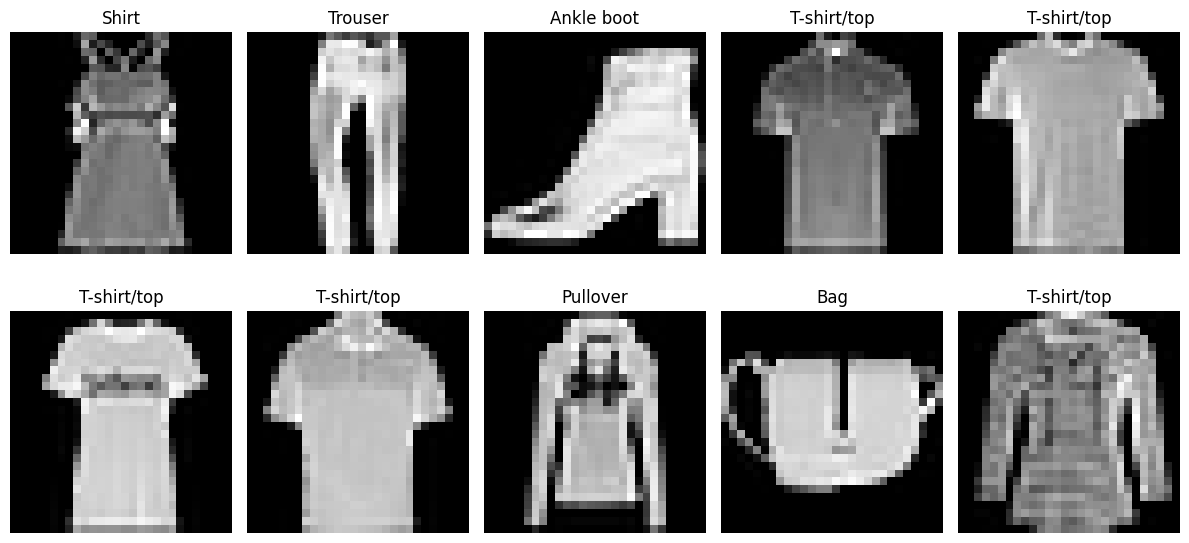

In [4]:
# Visualize 10 random images from the training dataset
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = random.randint(0, len(train_data) - 1)
    img, label = train_data[random_idx]
    show_image(img, label)

plt.tight_layout()
plt.show()

In [5]:
# Get a sample batch of images and labels
images, labels = next(iter(train_dataloader))
print(f"Batch image tensor shape: {images.shape}")
print(f"Batch label tensor shape: {labels.shape}")

Batch image tensor shape: torch.Size([64, 1, 28, 28])
Batch label tensor shape: torch.Size([64])


## Understanding Conv2d Layer

The `nn.Conv2d` is the cornerstone of CNNs in PyTorch. It applies a 2D convolution over an input signal composed of several input planes.

### Key Parameters:

- **in_channels**: Number of input channels (for grayscale images like FashionMNIST, this is 1)
- **out_channels**: Number of output channels (number of filters/kernels)
- **kernel_size**: Size of the convolving kernel (can be a single number or a tuple)
- **stride**: Stride of the convolution (default: 1)
- **padding**: Zero-padding added to both sides of the input (default: 0)

### How Convolution Works:

1. A filter (or kernel) slides over the input image
2. At each position, it performs an element-wise multiplication with the overlapping section of the image
3. The products are summed up to produce a single value in the output feature map
4. This process is repeated for each filter, creating multiple feature maps

![Convolution Details](https://miro.medium.com/v2/resize:fit:1400/1*1okwhewf5KCtIPaFib4XaA.gif)

Let's implement a single Conv2d layer and visualize its effect on a FashionMNIST image:


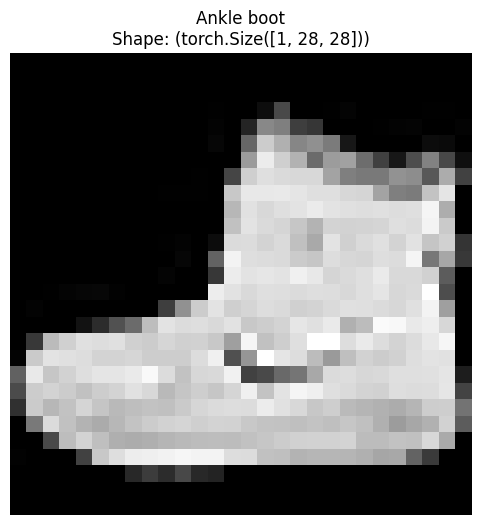

In [6]:
# Get a single image for demonstration
sample_image, sample_label = train_data[0]

plt.figure(figsize=(6, 6))
show_image(sample_image, sample_label, img_shape=str(sample_image.shape))
plt.show()

In [7]:
# Define a Conv2d layer
conv_layer = nn.Conv2d(
    in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1
)

# Apply the convolutional layer to the sample image
# Add batch dimension to the image tensor
sample_image_batch = sample_image.unsqueeze(0)  # Shape: (1, 1, 28, 28)
output_features = conv_layer(sample_image_batch)

print(f"Input image tensor shape: {sample_image_batch.shape}")
print(f"Output feature tensor shape: {output_features.shape}")

Input image tensor shape: torch.Size([1, 1, 28, 28])
Output feature tensor shape: torch.Size([1, 6, 28, 28])


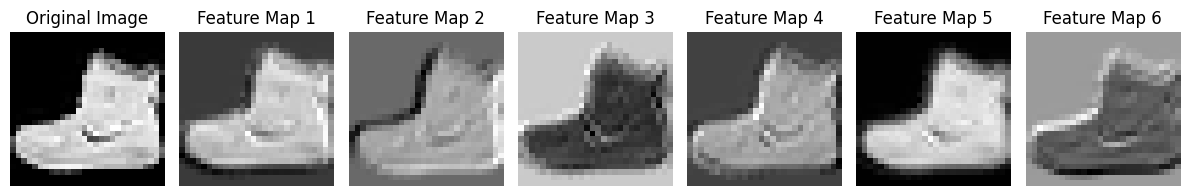

In [8]:
# Visualize original image and feature maps
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 7, 1)
show_image(sample_image, sample_label, img_shape=str(sample_image.shape))
plt.title("Original Image")

# Feature maps
for i in range(6):
    plt.subplot(1, 7, i + 2)
    feature_map = output_features[0, i, :, :].detach().numpy()
    plt.imshow(feature_map, cmap="gray")
    plt.axis("off")
    plt.title(f"Feature Map {i+1}")

plt.tight_layout()
plt.show()

What happens in Conv2d:

1. The input image (28x28) is convolved with 6 different 3x3 filters.
2. Each filter produces one separate feature map (output channel).
3. With padding=1, the output feature maps maintain the same spatial dimensions (28x28).
4. The values in each feature map represent detected patterns.


## Understanding MaxPool2d Layer

The `nn.MaxPool2d` layer is used to reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer. This serves two main purposes:

1. It reduces the computational load
2. It helps with feature extraction by providing a form of translation invariance

### Key Parameters:

- **kernel_size**: The size of the window to take the maximum over
- **stride**: The stride of the window (default: kernel_size)
- **padding**: Implicit zero padding to be added on both sides (default: 0)

### How MaxPooling Works:

1. A sliding window moves across the feature map
2. For each window position, it selects the maximum value
3. This maximum value becomes the value in the output feature map for that position
4. This effectively downsamples the feature map, reducing its dimensions

Let's implement a MaxPool2d layer and visualize its effect:


In [9]:
# Define a MaxPool2d layer
pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply the pooling layer to the output features
pooled_features = pool_layer(output_features)

print(f"Before pooling feature tensor shape: {output_features.shape}")
print(f"After pooling feature tensor shape: {pooled_features.shape}")

Before pooling feature tensor shape: torch.Size([1, 6, 28, 28])
After pooling feature tensor shape: torch.Size([1, 6, 14, 14])


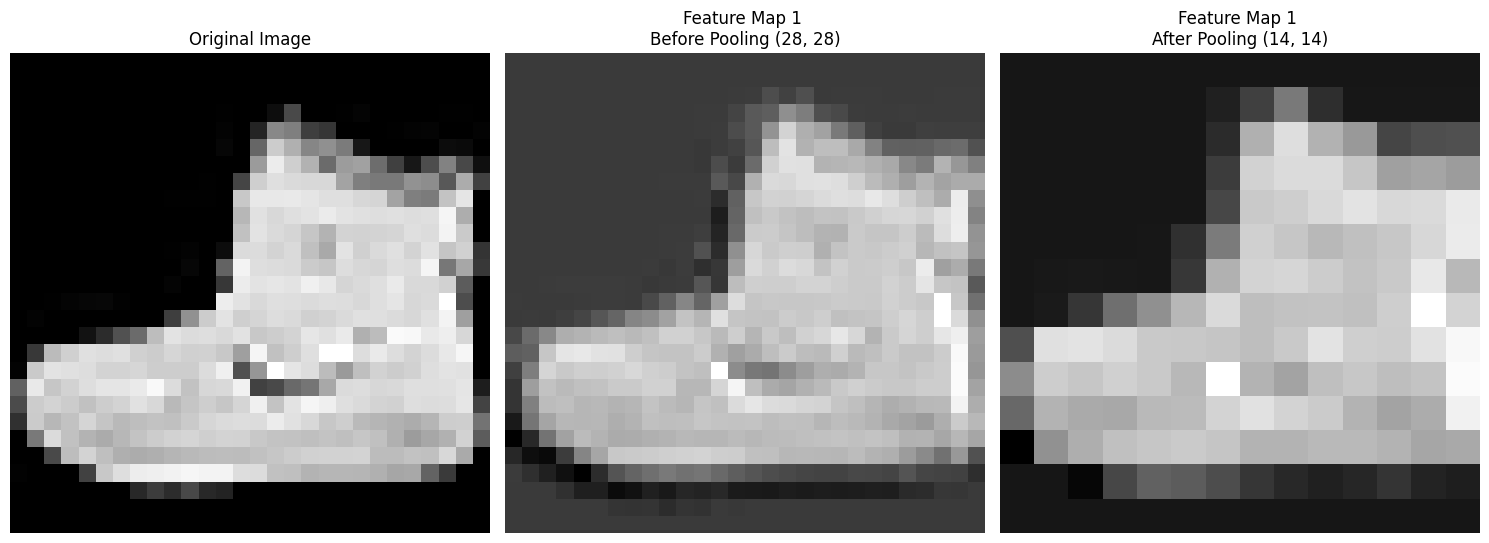

In [10]:
# Visualize the effect of pooling
plt.figure(figsize=(15, 6))

# Visualize the first feature map before and after pooling
feature_map_idx = 0

# Original feature map
plt.subplot(1, 3, 1)
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Feature map before pooling
feature_map_before_pool = output_features[0, feature_map_idx].detach().numpy()
plt.subplot(1, 3, 2)
plt.imshow(feature_map_before_pool, cmap="gray")
plt.title(
    f"Feature Map {feature_map_idx+1} \nBefore Pooling {feature_map_before_pool.shape}"
)
plt.axis("off")

# Feature map after pooling
feature_map_after_pool = pooled_features[0, feature_map_idx].detach().numpy()
plt.subplot(1, 3, 3)
plt.imshow(feature_map_after_pool, cmap="gray")
plt.title(
    f"Feature Map {feature_map_idx+1} \nAfter Pooling {feature_map_after_pool.shape}"
)
plt.axis("off")

plt.tight_layout()
plt.show()

## Additional Important CNN Layers

Before we build our full model, let's understand a few more key components:

### ReLU Activation

The Rectified Linear Unit (ReLU) is the most commonly used activation function in CNNs:

- It replaces all negative values with zero: f(x) = max(0, x)
- Advantages:
  - Simple and computationally efficient
  - Helps mitigate the vanishing gradient problem
  - Introduces non-linearity to allow the network to learn complex patterns

![ReLU Activation Function](https://miro.medium.com/v2/resize:fit:1400/1*XxxiA0jJvPrHEJHD4z893g.png)

### Fully Connected (Linear) Layers

After extracting features with convolutional and pooling layers, we flatten the output and connect it to fully connected (Linear) layers for classification:

- These layers connect every input to every output
- They're used to make the final classification decision based on the extracted features

### Flatten Layer

The flatten operation reshapes the multi-dimensional feature maps into a 1D vector:

- This is necessary before passing the data to fully connected layers
- It preserves all the information but changes the shape

Let's see these layers in action:


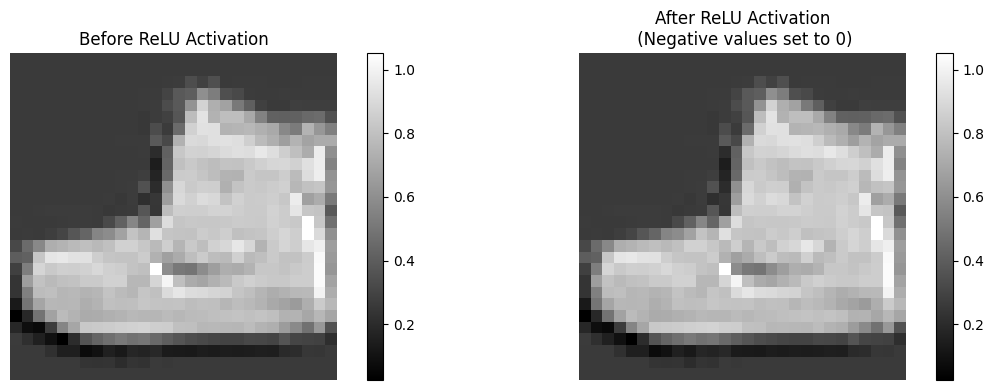

In [11]:
# Demonstration of ReLU activation
relu = nn.ReLU()

# Apply ReLU to the output features
activated_features = relu(output_features)

# Visualize the effect of ReLU activation
plt.figure(figsize=(12, 4))

# Before ReLU
plt.subplot(1, 2, 1)
plt.imshow(output_features[0, 0].detach().numpy(), cmap="gray")
plt.title("Before ReLU Activation")
plt.colorbar()
plt.axis("off")

# After ReLU
plt.subplot(1, 2, 2)
plt.imshow(activated_features[0, 0].detach().numpy(), cmap="gray")
plt.title("After ReLU Activation\n (Negative values set to 0)")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Demonstrate flattening operation
print(f"Shape before flattening: {pooled_features.shape}")

# Flatten the pooled features (keeping batch dimension)
flattened = torch.flatten(pooled_features, start_dim=1)
print(f"Shape after flattening: {flattened.shape}")  # This is [1, 6*14*14]

Shape before flattening: torch.Size([1, 6, 14, 14])
Shape after flattening: torch.Size([1, 1176])


In [13]:
# Demonstration a Linear layer
# Input features from flattening: 6*14*14 = 1176
# Output features: 10 (number of classes)
fc_layer = nn.Linear(in_features=6 * 14 * 14, out_features=10)

# Apply the fully connected layer
logits = fc_layer(flattened)
print(f"Logits shape: {logits.shape}")  # This is [1, 10]

Logits shape: torch.Size([1, 10])


In [14]:
# Convert logits to probabilities using softmax
probabilities = torch.softmax(logits, dim=1)
print(f"Predicted class probabilities: {probabilities}")

Predicted class probabilities: tensor([[0.0813, 0.1335, 0.1133, 0.0728, 0.0960, 0.0666, 0.0787, 0.1385, 0.0917,
         0.1276]], grad_fn=<SoftmaxBackward0>)


In [15]:
# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted class: {predicted_class} ({class_names[predicted_class]})")
print(f"True class: {sample_label} ({class_names[sample_label]})")

Predicted class: 7 (Sneaker)
True class: 9 (Ankle boot)


## Building the TinyVGG Model

Now that we understand the key components of CNNs, let's build a simple but effective model called TinyVGG. This is a scaled-down version inspired by the VGG architecture but with significantly fewer parameters.

You can checkout [CNN Explainer](https://poloclub.github.io/cnn-explainer/) to visualize the architecture and operations of CNNs. The architecture used in the explainer is TinyVGG which we will implement.

![VGG Architecture](https://miro.medium.com/v2/resize:fit:1400/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

### TinyVGG Architecture:

1. **Convolutional Block 1**:

   - Conv2d layer (in_channels=1, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - MaxPool2d layer (kernel_size=2, stride=2)

2. **Convolutional Block 2**:

   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - MaxPool2d layer (kernel_size=2, stride=2)

3. **Classifier**:
   - Flatten layer
   - Linear layer (in_features=10*7*7, out_features=10)

Let's implement this architecture:


In [16]:
class TinyVGG(nn.Module):
    def __init__(
        self, input_channels: int = 1, hidden_units: int = 10, output_classes: int = 10
    ):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                kernel_size=3,  # This is a 3x3 filter
                padding=1,  # Padding of 1 to maintain spatial dimensions
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),  # Output: [batch_size, hidden_units, 14, 14]
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),  # Output: [batch_size, hidden_units, 7, 7]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  # Output: [batch_size, hidden_units * 7 * 7]
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


model = TinyVGG(
    input_channels=1,  # FashionMNIST has 1 channel (grayscale)
    hidden_units=10,  # Number of filters in conv layers
    output_classes=10,  # Number of classes in FashionMNIST
).to(device)

print(model)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


In [17]:
# Track the tensor dimensions through our model
def track_tensor_dimensions(model, input_tensor):
    """
    Tracks and prints the tensor dimensions as it flows through the model.
    """
    # Original input
    print(f"Input tensor shape: {input_tensor.shape}")

    # Conv Block 1
    conv_block_1_output = model.conv_block_1(input_tensor)
    print(f"After Conv Block 1: {conv_block_1_output.shape}")

    # Conv Block 2
    conv_block_2_output = model.conv_block_2(conv_block_1_output)
    print(f"After Conv Block 2: {conv_block_2_output.shape}")

    # Flattened output
    flattened = torch.flatten(conv_block_2_output, start_dim=1)
    print(f"After Flattening: {flattened.shape}")

    # Final output
    output = model.classifier(flattened)
    print(f"Final output (logits): {output.shape}")

    return output


# Create a sample batch to track dimensions
sample_batch, _ = next(iter(train_dataloader))
sample_batch = sample_batch.to(device)[:1]  # Use just one sample

# Track tensor dimensions through the model
with torch.inference_mode():  # Disable gradient tracking
    _ = track_tensor_dimensions(model, sample_batch)

Input tensor shape: torch.Size([1, 1, 28, 28])
After Conv Block 1: torch.Size([1, 10, 14, 14])
After Conv Block 2: torch.Size([1, 10, 7, 7])
After Flattening: torch.Size([1, 490])
Final output (logits): torch.Size([1, 10])


In [18]:
# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Display model summary with layer names and parameter counts
print("\nModel Summary:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,} parameters")

Total trainable parameters: 7,740

Model Summary:
conv_block_1.0.weight: 90 parameters
conv_block_1.0.bias: 10 parameters
conv_block_1.2.weight: 900 parameters
conv_block_1.2.bias: 10 parameters
conv_block_2.0.weight: 900 parameters
conv_block_2.0.bias: 10 parameters
conv_block_2.2.weight: 900 parameters
conv_block_2.2.bias: 10 parameters
classifier.1.weight: 4,900 parameters
classifier.1.bias: 10 parameters


In [19]:
# We can also use torchsummary for a detailed model summary
# Important: If you are running on MPS, this will need to be done on CPU
print("\nDetailed Model Summary:")
torchsummary.summary(
    model.to("cpu"), input_size=(1, 28, 28), device="cpu"
)  # FashionMNIST image size


Detailed Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                   [-1, 10]           4,910
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
----------

## Setting Up Training (Loss Function and Optimizer)

Before we train our model, we need to define:

1. **Loss Function**: Measures how far our model's predictions are from the true labels. For multi-class classification like FashionMNIST, we use Cross-Entropy Loss.

2. **Optimizer**: Updates the model's weights based on the calculated gradients to minimize the loss. We'll use Adam, which is a popular optimization algorithm that adapts the learning rate for each parameter.

3. **Evaluation Metrics**: To track our model's performance during training, we'll use accuracy (proportion of correctly classified images).

Let's set these up:


In [20]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


# Define function to calculate accuracy
def calculate_accuracy(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """Calculate accuracy given true and predicted labels."""
    y_pred_classes = torch.argmax(y_pred, dim=1)
    correct = torch.eq(y_pred_classes, y_true).sum().item()
    accuracy = correct / len(y_true) * 100
    return accuracy

## Training and Evaluation Loop

Now we'll implement a training loop that:

1. Iterates over the training data for a specified number of epochs
2. For each batch:
   - Performs a forward pass through the model
   - Calculates the loss
   - Performs backpropagation
   - Updates the model parameters
3. Evaluates the model on the test set after each epoch
4. Tracks and reports metrics (loss and accuracy)

This process helps the model learn patterns in the data and improve its predictions over time.


In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
) -> tuple[float, float]:
    model.train()

    # Initialize metrics
    train_loss, train_acc = 0.0, 0.0

    # Create progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    # Loop through batches
    for batch, (X, y) in enumerate(progress_bar):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Calculate accuracy
        acc = calculate_accuracy(y, y_pred)
        train_acc += acc

        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Backward pass
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

    # Calculate average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: str,
) -> tuple[float, float]:
    model.eval()

    # Initialize metrics
    test_loss, test_acc = 0.0, 0.0

    # Disable gradient tracking
    with torch.inference_mode():
        # Create progress bar
        progress_bar = tqdm(dataloader, desc="Testing", leave=False)

        # Loop through batches
        for batch, (X, y) in enumerate(progress_bar):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # 3. Calculate accuracy
            acc = calculate_accuracy(y, y_pred)
            test_acc += acc

    # Calculate average metrics
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [22]:
import time

EPOCHS = 5
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

print(f"Training TinyVGG on {device} for {EPOCHS} epochs...\n")

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    start_time = time.time()

    train_loss, train_acc = train_step(
        model, train_dataloader, loss_fn, optimizer, device
    )
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Store results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
        f"Time: {epoch_duration:.2f}s"
    )

end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f}s")

Training TinyVGG on cpu for 5 epochs...



Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.6280, Train Acc: 76.99% | Test Loss: 0.4578, Test Acc: 83.54% | Time: 24.16s


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.3888, Train Acc: 86.06% | Test Loss: 0.3790, Test Acc: 86.75% | Time: 23.89s


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.3455, Train Acc: 87.46% | Test Loss: 0.3500, Test Acc: 87.81% | Time: 23.97s


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3188, Train Acc: 88.48% | Test Loss: 0.3477, Test Acc: 87.68% | Time: 24.17s


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3000, Train Acc: 89.11% | Test Loss: 0.3219, Test Acc: 88.40% | Time: 23.96s

Total training time: 23.96s


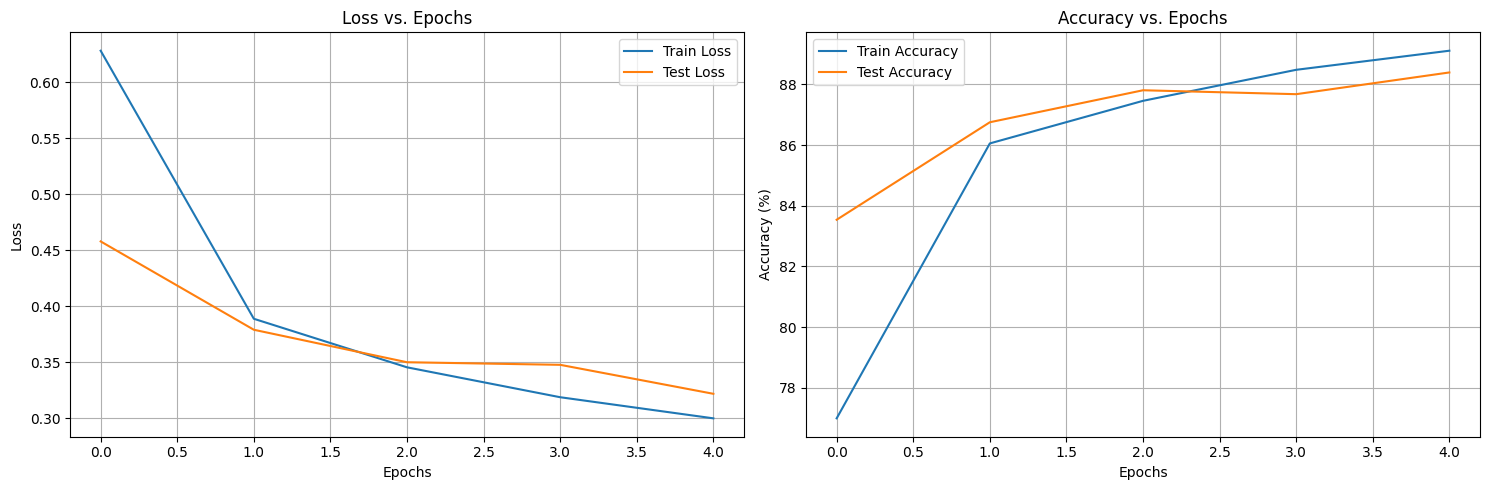

In [23]:
# Visualize training results
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), results["train_loss"], label="Train Loss")
plt.plot(range(EPOCHS), results["test_loss"], label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), results["train_acc"], label="Train Accuracy")
plt.plot(range(EPOCHS), results["test_acc"], label="Test Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Evaluation with Confusion Matrix

A confusion matrix is a table that visualizes the performance of a classification model. It shows:

- True positives: Correctly predicted positive instances
- False positives: Incorrectly predicted positive instances
- True negatives: Correctly predicted negative instances
- False negatives: Incorrectly predicted negative instances

By analyzing the confusion matrix, we can:

1. Identify which classes the model confuses with each other
2. Understand if the model has a bias toward certain classes
3. Find opportunities to improve the model's performance

![Confusion Matrix Visualization](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

Let's create a confusion matrix to evaluate our trained TinyVGG model:


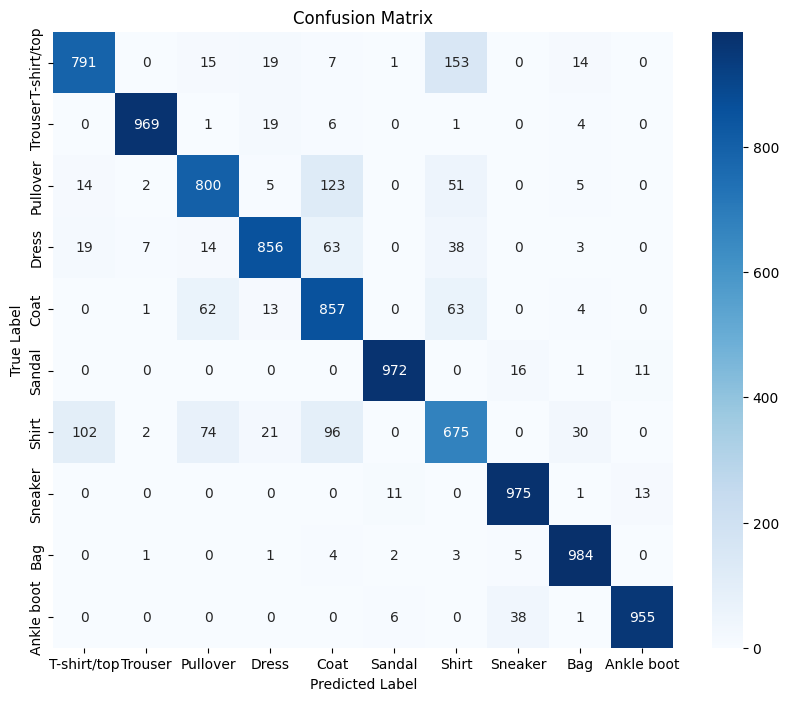

/var/folders/yt/cn6f6s5j333_0wsr6tf6bb580000gn/T/ipykernel_46637/2106725634.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=per_class_accuracy, palette="viridis")


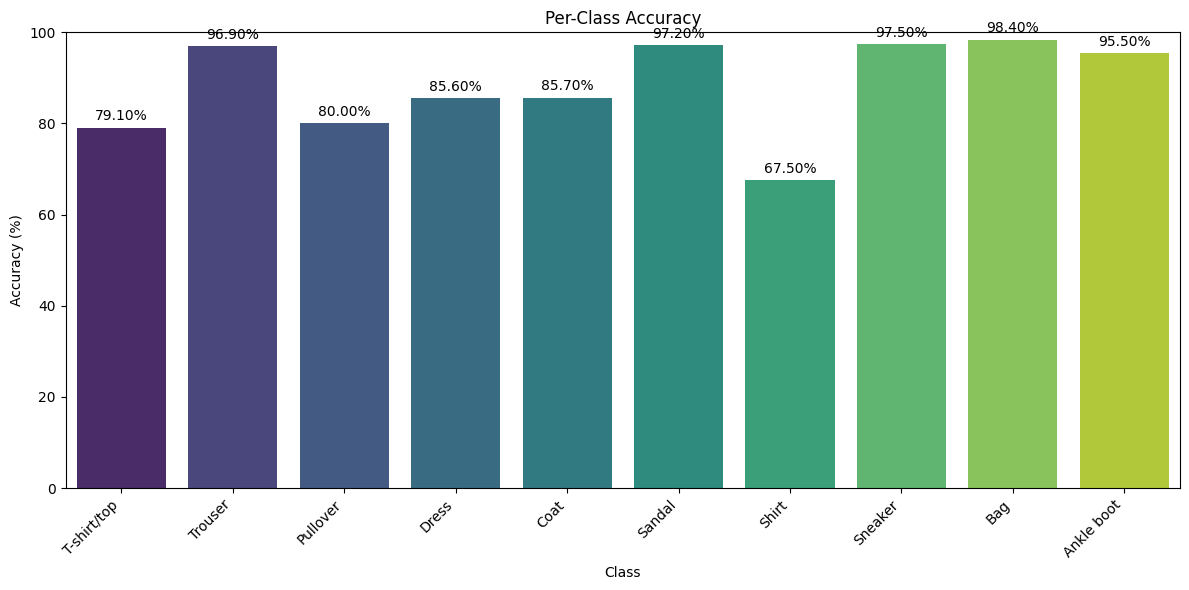

In [24]:
# Create functions to get predictions from our model
def make_predictions(model, data_loader, device):

    model.eval()
    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)

            # Append to lists
            y_preds.append(y_pred_labels.cpu())
            y_true.append(y.cpu())

    # Concatenate lists
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


# Make predictions on the test set
y_preds, y_true = make_predictions(
    model=model, data_loader=test_dataloader, device=device
)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true.numpy(), y_preds.numpy())

# Create a pretty confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100

# Display per-class accuracy and show accuracy number on the bar per class
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_names, y=per_class_accuracy, palette="viridis")

plt.ylim(0, 100)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha="right")

# Add accuracy values on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.2f}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

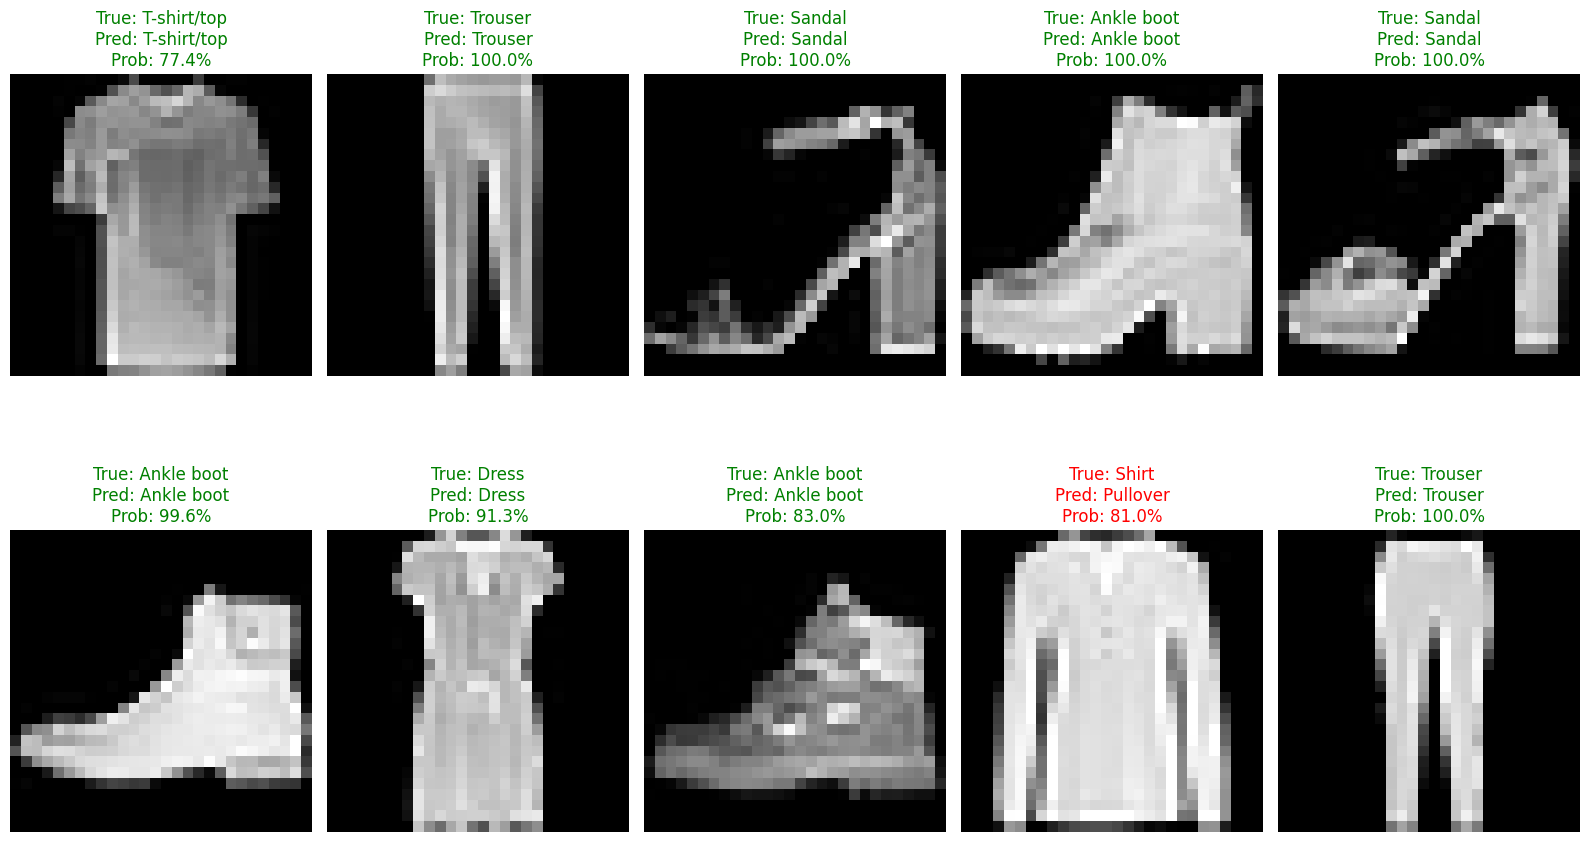

In [32]:
# Let's visualize some predictions
def plot_random_predictions(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    class_names: list,
    device: torch.device,
    n: int = 10,
):
    model.eval()
    dataset = data_loader.dataset

    indices = torch.randint(0, len(dataset), (n,))
    images = torch.stack([dataset[i][0] for i in indices]).to(device)
    labels = torch.tensor([dataset[i][1] for i in indices]).to(device)

    with torch.inference_mode():
        pred_logits = model(images[:n])
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)

    # Plot images with predictions
    plt.figure(figsize=(16, 10))
    for i in range(n):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap="gray")

        # Get prediction information
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]
        prob = torch.max(pred_probs[i]).item() * 100

        # Set color based on correct/incorrect prediction
        color = "green" if pred_labels[i] == labels[i] else "red"

        # Add title with predictions
        plt.title(
            f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.1f}%", color=color
        )
        plt.axis(False)

    plt.tight_layout()
    plt.show()


# Visualize some predictions
plot_random_predictions(
    model=model,
    data_loader=test_dataloader,
    class_names=class_names,
    device=device,
    n=10,
)

## Conclusion

In this notebook, we've explored Convolutional Neural Networks (CNNs) using PyTorch and the FashionMNIST dataset. Here's a summary of what we've learned:

1. **CNN Fundamentals**:

   - We explored the key components of CNNs, including convolutional layers, pooling layers, and fully connected layers
   - We visualized how each layer transforms the input data

2. **TinyVGG Architecture**:

   - We built a simplified version of the VGG architecture
   - We tracked tensor dimensions through the model to understand how data flows
   - We analyzed model parameters

3. **Training Process**:

   - We set up loss function (Cross-Entropy Loss) and optimizer (Adam)
   - We implemented a comprehensive training and evaluation loop
   - We visualized training progress over epochs

4. **Model Evaluation**:
   - We used accuracy as our primary metric
   - We created a confusion matrix to understand model strengths and weaknesses
   - We analyzed per-class accuracy to identify which classes were harder to classify
   - We visualized model predictions on test examples

### Further Improvements

To improve the model's performance, you could try:

1. **Architecture Modifications**:

   - Add more convolutional layers or increase filters
   - Experiment with different kernel sizes
   - Implement skip connections

2. **Regularization Techniques**:

   - Add dropout layers
   - Apply batch normalization
   - Use data augmentation

3. **Hyperparameter Tuning**:

   - Adjust learning rate
   - Try different optimizers
   - Train for more epochs

4. **Transfer Learning**:
   - Use pre-trained models like ResNet, VGG, or EfficientNet
   - Fine-tune on the FashionMNIST dataset

CNNs remain a cornerstone of computer vision tasks, and the principles learned here apply to more complex models and datasets.
